In [4]:
import math

import matplotlib.animation as anim
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
from scipy.integrate import solve_ivp

# Dynamika ruchu pieszych
autorzy:
Kacper Borys, Karolina Pyś

### Wstęp
Dynamika ruchu pieszych to zagadnienie, które każdy z nas może obserwować na co dzień. Zrozumienie, modelowanie i symulacja tego zjawiska są istotne dla projektowania bezpiecznych i efektywnych przestrzeni publicznych. 

Jest to złożonym zjawiskiem, które obejmuje indywidualne decyzje, interakcje społeczne oraz reakcje na zmiany warunków otoczenia. Uwzględnienie wszystkich tych czynników dla każdego pieszego jest wręcz niemożliwe. Okazuje się jednak, że nawet mocno uproszczone modele pozwalają odzorować dynamikę tę w sposób zbliżony do obserwowanej rzeczywistości. 

W projekcie skupimy się na wykorzystaniu równań różniczkowych do modelowania tego zagadnienia, wykorzystując metody numeryczne do rozwiązania uzykanych układów równań. W kontekście ruchu pieszych, równania różniczkowe pozwalać nam będą uwzględnić zmiany prędkości, kierunku i pozycji każdego pieszego w zależności od czasu, a także brać pod uwagę oddziaływania między nimi. 

### Opis zjawiska i przyjęty model

Korzystając z zasad dynamiki Newtona, ruch każdego pieszego możemy opisać rówaniem

$$ \frac{\operatorname{d}\!\boldsymbol{x_i}}{\operatorname{d}\!t} = \boldsymbol{v}_i $$
$$m_i\frac{\operatorname{d}\!\boldsymbol{v_i}}{\operatorname{d}\!t} = \boldsymbol{F}_i$$ 

gdzie  
$ \boldsymbol{x}_i$ - wektor położenia pieszego $i$  
$ \boldsymbol{v}_i $ - wektor prędkości pieszego $i$  
$ m_i $- masa pieszego $i$  
$\boldsymbol{F}_i$ - siła wypadkowa działająca na pieszego $i$

Kluczowym elementem w budownie modelu jest odpowiednie wybranie sił składających się na ruch pieszego. Bazując na [[1](#bibliografia)] i [[3](#bibliografia)] wybraliśmy dwie siły, które mają największe znaczenie dla ruchu.  

Pierwsza z nich to *driving force* oznaczana $\boldsymbol{F}_{i}^{drv}$. Związana jest ona z kierunkiem w jakim pieszy zamierza się poruszać oraz prędkością, którą chciałby w tym ruchu utrzymywać - informacje te zawarte są w wektorze $\boldsymbol{v}_i^0$. Wyraża się ona wzorem:
$$\boldsymbol{F}_{i}^{drv} = m_i \frac{v_i^0 \boldsymbol - v_i}{\tau_i} $$
gdzie $\tau_i$ jest współczynnikiem związanym z przyspieszeniem.  

Drugim czynnikim dyktującym ruch pieszego są niewątpliwie interakcje z otoczeniem. Składają się one z interakcji z innymi pieszymi oraz infrastrukturą. Suma tych dwóch sił to *repulsive force* oznaczana $\boldsymbol{F}_{i}^{rep} = \boldsymbol{F}_{i}^{rep_1} + \boldsymbol{F}_{i}^{rep_2} $.  
Składnik związany z innymi pieszymi obliczamy jako sumę siły oddziaływań między poszczególnymi pieszymi
$$ \boldsymbol{F}_{i}^{rep_1} = \sum_{j(\neq)i} - \nabla A (d_{ij} - D)^{-B} $$ 
gdzie  
$ D $- odległość, jaką piesi chcą utrzymywać między sobą  
$d_{ij} = \ ||{\boldsymbol{x_i}-\boldsymbol{x_j}}\!\ || > D$ - odległość między pieszymi  
$A, B$ - współczynniki stałe dla wszystkich pieszych  

Drugi składnik związany z przeszkodami w ruchu wynikającymi z infrastruktury wyznaczamy z następującego wzoru.
$$ \boldsymbol{F}_{i}^{rep_2} = - \nabla A (d_{i\perp} - D/2)^{-B}$$
gdzie  
$d_{i\perp}$ - najkrótsza odległość do najbliższej przeszkody.  


Rozpatrując ruch wielu pieszych otrzymujemy zatem układ równań, w których każdego pieszego opisują dwa następujące równania
$$ \frac{\operatorname{d}\!\boldsymbol{x_i}}{\operatorname{d}\!t} = \boldsymbol{v}_i $$
$$m_i\frac{\operatorname{d}\!\boldsymbol{v_i}}{\operatorname{d}\!t} = \boldsymbol{F}_{i}^{drv} + \boldsymbol{F}_{i}^{rep_1} + \boldsymbol{F}_{i}^{rep_2} $$ 

Wartości współczynników występujących w powyższych wzorach przyjmujemy na podstawie przytoczonych artykułów stałe dla wszystkich pieszych i wynoszące odpowiednio  
$ m = 1,\ \tau = 0.5,\ A = 0.2,\ B = 1 $. Współczynnik $D$ związany z odległością miedzy pieszymi i przeszkodamy dobieramy zależnie od zastosowań, w granicy 1 metra.


Na tej podstawie wyznaczamy położenie i prędkość każdego pieszego w kolejnych chwilach czasu.


### Uzyskane wyniki
Zaimplementowane przez nas zostały dwie metody numeryczne - Eulera i Runge Kutta.

In [5]:

def solve_runge_kutta_4(f, inital_conditions, params, time_span, time_step):
    n = (time_span[1]-time_span[0])*time_step

    y = np.zeros((n, *inital_conditions.shape))
    y[0] = inital_conditions
    t = time_span[0]
    step = 1/time_step
    

    for i in range(1, n):
        k_1 = f(t, y[i-1], *params)
        k_2 = f(t + step/2, y[i-1] + step*k_1*2, *params)        
        k_3 = f(t + step/2, y[i-1] + step*k_2*2, *params)
        k_4 = f(t + step, y[i-1] + step*k_3, *params)

        t += step
        y[i] = y[i-1] + (step/6)*(k_1 + 2*k_2 + 2*k_3 + k_4)

    return y[::(time_span[1]-time_span[0])]

In [6]:
def solve_euler(f, inital_conditions, params, time_span, time_step):

    n = (time_span[1]-time_span[0])*time_step
    y = np.zeros((n, *inital_conditions.shape))
    y[0] = inital_conditions
    t = time_span[0]
    step = 1/time_step

    for i in range(1, n):
        y[i] = y[i-1] + step*f(t, y[i-1], *params)
        t += step

    return y[::(time_span[1]-time_span[0])]

W pierwszym przybliżeniu rozpatrujemy ruch pieszych w jednym wymiarze bez uwzględniania *repulsive force*. Przyjrzymy się prędkościom poszczególnych pieszych w czasie.  
W tym celu rozwiążemy równanie
$$ m_i\frac{\operatorname{d}\!\boldsymbol{v_i}}{\operatorname{d}\!t} = \boldsymbol{F}_{i}^{drv} $$
sprowadzające się do 
$$ \frac{\operatorname{d}\!\boldsymbol{v_i}}{\operatorname{d}\!t} = \frac{v_i^0 \boldsymbol - v_i}{\tau_i} $$

In [10]:
#bez uwzględniania interakcji między pieszymi
def pedestrian_vel(t,v, v0, tau):
    dvdt = (v0 - v)/tau
    return dvdt


def system(t, y, v_0, tau):
    vel = y[len(y)//2:]

    dvdt = pedestrian_vel(t, vel, v_0, tau)

    return np.concatenate([vel, dvdt])

def analitical_pos(t, v_0, tau):
    return (v_0*(t + tau * math.exp((-1/tau) * t ) - tau))
    

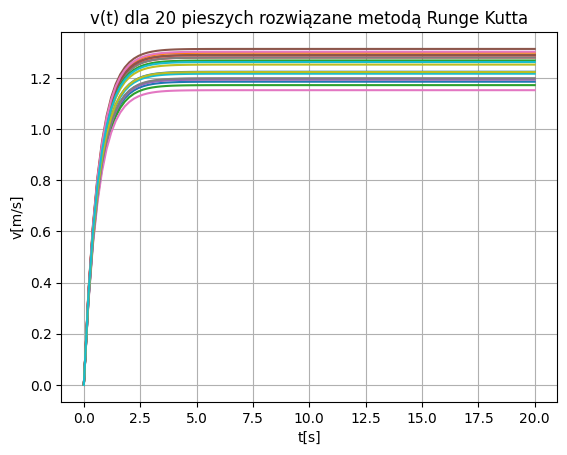

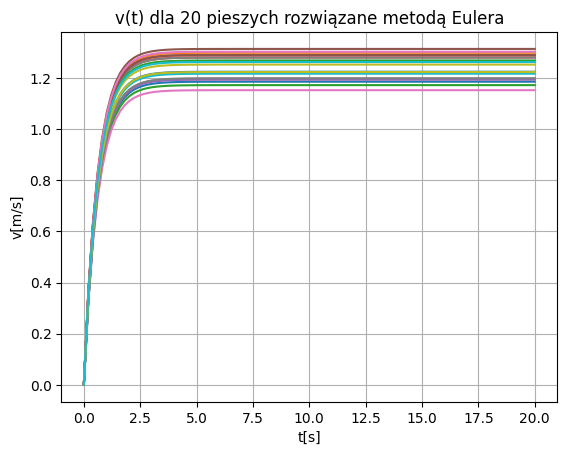

In [8]:
v0s = np.random.normal(1.24, 0.05, 20) #zgodnie z [1] strona 4
tau = 0.61

#initial conditions
v_0 = 0  
t = np.linspace(0,20,100)
time_step = 20/100

sol_rk = np.array([(solve_runge_kutta_4(pedestrian_vel, np.array([0]), (v0,tau), (0,20), 100)) for v0 in v0s ])
sol_eu = np.array([(solve_euler(pedestrian_vel, np.array([0]), (v0,tau),(0,20),100)) for v0 in v0s])
sol_analitical = [ [(v0*(1-math.exp((-1/tau)*t_i))) for  t_i in t] for v0 in v0s]

for i in range(20):
    plt.plot(t, sol_rk[i])
plt.title("v(t) dla 20 pieszych rozwiązane metodą Runge Kutta")
plt.xlabel('t[s]')
plt.ylabel('v[m/s]')
plt.grid()
plt.show()

plt.cla()

for i in range(20):
    plt.plot(t, sol_eu[i])
plt.title("v(t) dla 20 pieszych rozwiązane metodą Eulera")
plt.xlabel('t[s]')
plt.ylabel('v[m/s]')
plt.grid()
plt.show()

Możemy zaobserwować, że każdy pieszy dąży do swojej zamierzonej prędkości i po jej osiągnięciu utrzymuje ją. W związku z brakiem oddziaływań z otoczeniem nie ma przeszkód w poruszaniu się zamierzonym ruchem.  
Łatwo dostrzegalne są również różnice pomiędzy rozwiązaniem w zależności od zastosowanej metody.  
W przypadku tak uproszczonego zagadnienia jesteśmy w stanie znaleźć analityczne rozwiązanie równań i porównać je z uzyskanymi wynikami, aby ocenić, która metoda sprawdziła się lepiej w naszym zagadnieniu.

$$ \frac{\operatorname{d}\!\boldsymbol{v_i}}{\operatorname{d}\!t} = \frac{v_i^0 \boldsymbol - v_i}{\tau_i} $$
Korzystając z metody zmiennych rozdzielonym mamy
$$ \int \frac{\operatorname{d}\!\boldsymbol{v_i}}{\boldsymbol{v}_i^0 - \boldsymbol{v}_i}  = \int \frac{\operatorname{d}\! t}{\tau_i} $$  
stąd
$$ -\operatorname{ln}(\boldsymbol{v}_i^0 - \boldsymbol{v}_i) = \frac{t}{\tau} + C_1 $$
$$ \boldsymbol{v}_i^0 - \boldsymbol{v}_i =  C_2 e^{\frac{-t}{\tau}} $$
Zatem 
$$ \boldsymbol{v}_i = \boldsymbol{v}_i^0 + C_2 e^{\frac{-t}{\tau}} $$
Dodatkowo przyjmując warunku początkowe $  \boldsymbol{v}_i(0) = 0 $ mamy $ C_2 = - \boldsymbol{v}_i^0 $. Stąd otrzymujemy wzór
$$ \boldsymbol{v}_i(t) = \boldsymbol{v}_i^0(1 - e^{\frac{-t}{\tau}}) $$  
Idąc dalej
$$ \boldsymbol{x}_i(t) = \int \boldsymbol{v}_i(t) =  \boldsymbol{v}_i^0 \int (1 - e^{\frac{-t}{\tau}}) $$
Jeszcze dalej
$$ \boldsymbol{x}_i(t) = \boldsymbol{v}_i^0(t + \tau e^{\frac{-t}{\tau}} + C_3) $$
I końcowo dla $x_i(0) = x_i^0 = 0$, $C_3 = -\tau$
$$ \boldsymbol{x}_i(t) = \boldsymbol{v}_i^0(t + \tau e^{\frac{-t}{\tau}} - \tau) $$

### Porównanie dokładności metod Eulera i Runge-Kutta

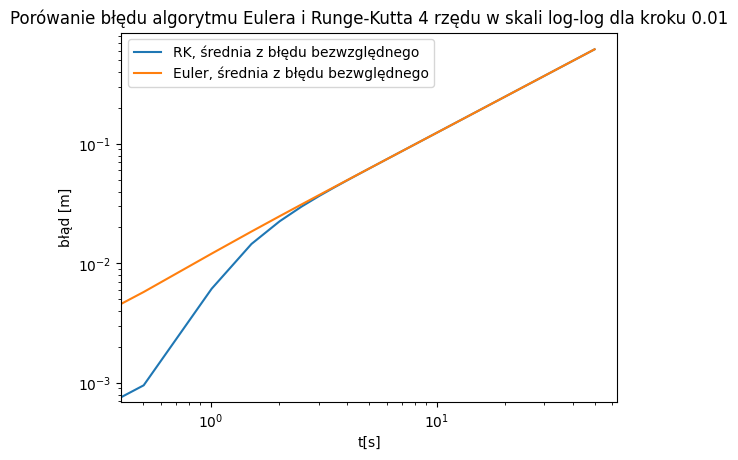

In [12]:
tau = 0.61
time_step = 100
t_range = (0, 50)
interval = np.linspace(*t_range, time_step)
pedestrians = 10
loop_count = 10



rk_error = np.zeros(time_step)
eu_error = np.zeros(time_step)


for _ in range(loop_count):
    v_0s = np.random.normal(1.24, 0.05, pedestrians)
    n = len(v_0s)

    sol_analitical = np.array([[analitical_pos(t, v_0, tau) for t in interval] for v_0 in v_0s])
    sol_rk = np.array([solve_runge_kutta_4(system, np.zeros(2), (v_0, tau), t_range, time_step) for v_0 in v_0s])
    sol_eu = np.array([solve_euler(system, np.zeros(2), (v_0, tau), t_range, time_step) for v_0 in v_0s])

    for i in range(pedestrians):
        rk_error += abs(sol_analitical[i] - sol_rk[i, :, 0])
        eu_error += abs(sol_analitical[i] - sol_eu[i, :, 0])

plt.xlabel('t[s]')
plt.ylabel('błąd [m]')
plt.loglog(interval, rk_error/(loop_count*pedestrians), label=f'RK, średnia z błędu bezwzględnego')
plt.loglog(interval, eu_error/(loop_count*pedestrians), label=f'Euler, średnia z błędu bezwględnego')
plt.title('Porówanie błędu algorytmu Eulera i Runge-Kutta 4 rzędu w skali log-log dla kroku 0.01')
plt.legend()



In [20]:
domain = np.array([10**x for x in range(1, 5)])
tau = 0.61
t_range = (0, 50)
rk_error_steps = []
euler_error_steps = []
pedestrians = 50
loop_count = 10

for time_step in domain:
    rk_error = np.zeros(time_step)
    eu_error = np.zeros(time_step)
    interval = np.linspace(*t_range, time_step)

    for _ in range(loop_count):
        v_0s = np.random.normal(1.24, 0.05, pedestrians)
        n = len(v_0s)

        sol_analitical = np.array([[analitical_pos(t, v_0, tau) for t in interval] for v_0 in v_0s])
        sol_rk = np.array([solve_runge_kutta_4(system, np.zeros(2), (v_0, tau), t_range, time_step) for v_0 in v_0s])
        sol_eu = np.array([solve_euler(system, np.zeros(2), (v_0, tau), t_range, time_step) for v_0 in v_0s])

        for i in range(pedestrians):
            rk_error += abs(sol_analitical[i] - sol_rk[i, :, 0])
            eu_error += abs(sol_analitical[i] - sol_eu[i, :, 0])
    
    rk_error_steps.append(rk_error/(loop_count*pedestrians))
    euler_error_steps.append(eu_error/(loop_count*pedestrians))

step_sizes = [1/timestep for timestep in domain]

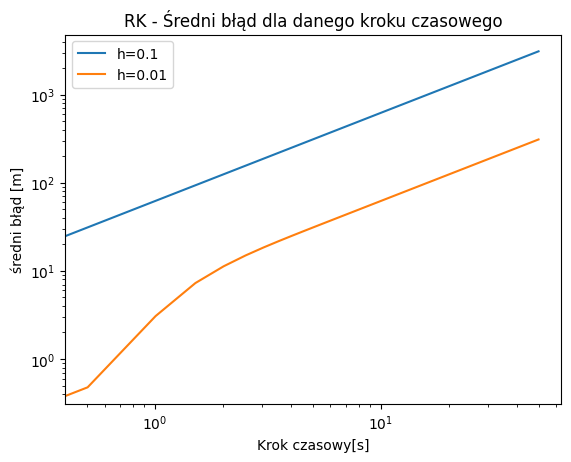

In [22]:
plt.xlabel('Krok czasowy[s]')
plt.ylabel('średni błąd [m]')
for i, t_step in enumerate(domain):
    plt.loglog(np.linspace(*t_range, t_step), rk_error_steps[i], label=f'h={step_sizes[i]}')
plt.title('RK - Średni błąd dla danego kroku czasowego')
plt.legend()

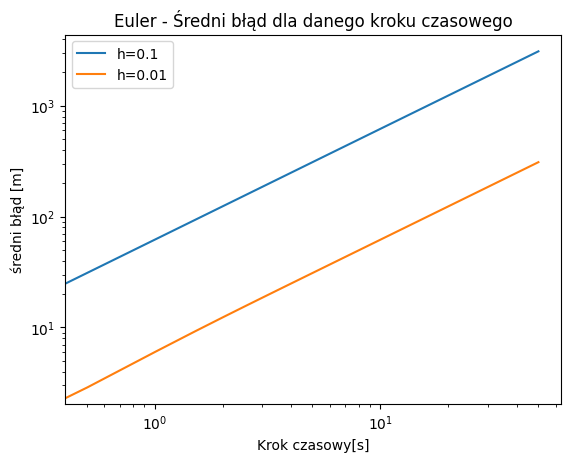

In [23]:
plt.xlabel('Krok czasowy[s]')
plt.ylabel('średni błąd [m]')
for i, t_step in enumerate(domain):
    plt.loglog(np.linspace(*t_range, t_step), euler_error_steps[i], label=f'h={step_sizes[i]}')
plt.title('Euler - Średni błąd dla danego kroku czasowego')
plt.legend()

Text(0.5, 1.0, 'Blad w ostatniej chwili czasowej vs krok czasowy')

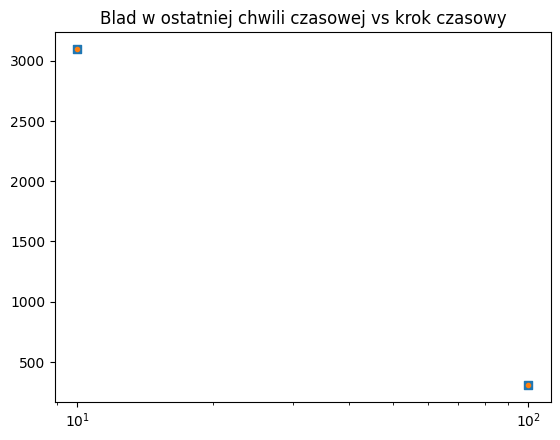

In [29]:
rk_last_step = [step[-1] for step in rk_error_steps]
euler_last_step = [step[-1] for step in euler_error_steps]

plt.scatter(domain, rk_last_step, label='rk', marker="s")
plt.scatter(domain, euler_last_step, label='euler', marker='.')
plt.xscale('log')
plt.title('Blad w ostatniej chwili czasowej vs krok czasowy')

Maleje

#### Ruch w dwóch wymiarach

Rozpatrywanie takiego ruchu jest jednak bardzo dużym uproszczeniem. Dlatego zdecydowaliśmy się na dokładniejsze przyjrzenie się modelowi w dwóch wymiarach, uwzględniając zarówno *driving force*, jak i *repulsive force*.

W tym przypadku otrzymujemy układ równań różniczkowych - po dwa dla każdego pieszego. Dlatego w tym modelu najpierw rozwiązujemy zagadnienia używająć funkcji wbudowanej z moduły scipy, aby później porównać wyniki z zaimplementowanych przez nas algorytmów.

#### Układ równań

In [78]:

def system(t, y, *params):
    
    y = y.reshape(2*n, 2)
    x = y[:n] # position
    v = y[n:] # velocity

    if len(params) == 12:
        driving_w, rep_w, walls_w, n, m, v_0, tau, a, b, d, e, boxes = params  
    else:
        driving_w, rep_w, walls_w, n, m, v_0, tau, a, b, d, e, boxes, t_k,em_exit = params 

    #driving forces dla systemu
    if rep_w<0.2: ##ewakuacja z paniką
        np.random.seed(21)
        panic = np.zeros((n,2))
        num_crowds = 5
        for i in range(num_crowds):
            for j in range ((i*int(n/num_crowds)),((i+1)*int(n/num_crowds))):
                if em_exit[0]-x[j][0] > 0:
                    dir_to_exit = (em_exit-x[j])/np.linalg.norm(em_exit-x[j]) 
                else:
                    dir_to_exit = np.array([em_exit[0]*2, np.random.choice([-1,1])])
                e_with_random = dir_to_exit + np.random.choice([-1,1,], size = (2))* np.random.uniform(0,0.04, size = (2))*max((np.random.uniform(low=0.5, high = 0.7)*t_k - t),0)  
                panic[j] = e_with_random/np.linalg.norm(e_with_random)
        new_e = panic
        driving_forces = np.array([(v_0[i] * new_e[i] - v[i])/tau[i] for i in range(n)])
    else:
        driving_forces = np.array([(v_0[i] * e[i] - v[i])/tau[i] for i in range(n)])
    
    
    #driving forces dla systemu
    driving_forces = np.array([(v_0[i] * e[i] - v[i])/tau[i] for i in range(n)])
    
    #repulsive forces dla wszystkich ludzi bez sumowania
    repulsive_forces = np.array([grad_rep_force_others(x[i], x[j], a[i], b[i], d[i])/m[i]  for i in range(n) for j in range(n) if i != j])
    #sumowanie 
    repulsive_forces = np.sum(repulsive_forces.reshape((n, n-1, 2)), axis=1)

    repulsive_forces_walls = np.array([grad_rep_force_walls(x[i], box, a[i], b[i], d[i])/m[i] for i in range(n) for box in boxes])
    repulsive_forces_walls = np.sum(repulsive_forces_walls.reshape((n, len(boxes), 2)), axis=1)
    
    total_forces = driving_w * driving_forces + rep_w * repulsive_forces + walls_w * repulsive_forces_walls
    # total_forces = np.array([F_i(force, e[i], v_0[i]) for i, force in enumerate(total_forces)])
    
    return np.concatenate([v, total_forces]).flatten()
    
def grad_rep_force_others(x_i, x_j, A, B, d_i):
    norm = np.linalg.norm(x_i-x_j)
    vector_diff = x_i - x_j
    dist = max(norm - d_i, 0)
    if dist:
        return B * (A / (norm)) * vector_diff * (dist) ** (-B - 1)
    
    return np.zeros_like(x_i)
    
    
def grad_rep_force_walls(x_i, box, A, B, d_i):
    #box ma kordynaty x,y oraz szerokosc i wysokosc
    #dziala sila z dolu/gory
    vector_diff = np.zeros_like(x_i)

    #dziala sila z gory/dolu
    if box[0] < x_i[0] < box[0] + box[2]:
        vector_diff = x_i - np.array([x_i[0], (2*box[1] + box[3]) / 2])
        #dystans od sciany
        d_i += box[3]
        
    #dziala sila z lewej/prawej
    elif box[1] < x_i[1] < box[1] + box[3]:
        vector_diff = x_i - np.array([(2*box[0] + box[2]) / 2, x_i[1]])
        #dystans od sciany
        d_i += box[2]
    
    
    norm = np.linalg.norm(vector_diff)
    dist = max(norm - d_i/2, 0)

    if dist:
        return B * (A / (norm)) * vector_diff * (dist) ** (-B - 1)
    
    return np.zeros_like(x_i)

def generate_positions(num_vectors, box, min_distance):
    min_x, min_y, width, height = box
    pos = []
    
    while len(pos) < num_vectors:
        vector = np.random.uniform([min_x, min_y], [min_x + width, min_y + height])
        if all(np.linalg.norm(np.array(vector) - np.array(existing_vector)) >= min_distance for existing_vector in pos):
            pos.append(vector)
    
    return np.array(pos)


# przechodzien sie zatrzyma ale nie pojdzie do tylu (i hope)
def F_i(force, direction, max_vel):
    if np.dot(force, direction) > 0:
        #predkosc wynikajaca z sily jest nie wieksza niz pożądana predkosc przechodnia
        return (force / np.linalg.norm(force)) * min(max_vel, np.linalg.norm(force))
    
    return np.zeros_like(force)

#### Symulacja ruchu w przeciwnych kierunkach
Pierwszą symulowaną przez nas sytuacją jest ruch dwóch grup pieszych w przeciwnych kierunkach na obszarze ograniczonym z dwóch stron. Można identyfikować to z ruchem na chodniku, korytarzu, czy przejściu dla pieszych.

Aby otrzymać model tej sytuacji ustalamy odpowiednie warunki początkowe dla każdego pieszego. Pozycja początkowa połowy z nich jest po jednej, a połowa po drugiej stronie obszaru, prędkości początkowe wszystkich pieszych są równe 0, a zamierzone prędkości mają zwrot odpowiednio w prawo i lewo. 

In [79]:
TIME_STEP = 100
T_SPAN = (0, 40)

particles = 10
#ida w lewo
crowd_1 = generate_positions(particles/2, (-10, -2, 2.5, 4), 1)
crowd_1_direction = [np.array([1,0])]*int(particles/2)


#ida w prawo
crowd_2 = generate_positions(particles/2, (7.5, -2, 2.5, 4), 1)
crowd_2_direction = [np.array([-1,0])]*int(particles/2)


vel = np.zeros((particles, 2))

inital_conditions = np.concatenate([crowd_1, crowd_2, vel]).flatten()


e = np.concatenate([crowd_1_direction, crowd_2_direction])

#params
driving_w, rep_w, walls_w = [1,1,1]
m = np.random.rand(particles) + 1
v_0 = np.absolute(np.random.normal(1.24, 0.05, particles)) #zgodnie z artykułem
tau = np.full(particles, .5) #też zgodnie z artykułem - dla wszystkich równe
a = np.full(particles, .2)
b = np.full(particles, 1)
d = np.full(particles, .5)
boxes = np.array([[-15, -2.5, 30, 0], [-15, 2.5, 30, 0]])
params = (driving_w, rep_w, walls_w, particles, m, v_0, tau, a, b, d, e, boxes)

solution1 = solve_ivp(system, T_SPAN, inital_conditions, args=params, t_eval=np.linspace(T_SPAN[0], T_SPAN[1], TIME_STEP))
y = np.transpose(solution1.y).reshape(TIME_STEP, 2, particles, 2)

solution2 = solve_runge_kutta_4(system, inital_conditions, params, T_SPAN, TIME_STEP)
y_rk4 = solution2.reshape(TIME_STEP, 2, particles, 2)

solution3 = solve_euler(system, inital_conditions, params, T_SPAN, TIME_STEP)
y_euler = solution3.reshape(TIME_STEP, 2, particles, 2)



In [80]:
%%capture
fig, ax = plt.subplots(figsize=(5,5))

def update(i):
    ax.clear()
    for particle in range(particles):
        ax.scatter(y[i, 0, particle, 0], y[i, 0, particle, 1])
    ax.plot(np.linspace(-12, 12, 100), np.full(100,2.5), color = "gray", linewidth = 2)
    ax.plot(np.linspace(-12, 12, 100), np.full(100,-2.5), color = "grey", linewidth = 2)

    ax.set_xlim(-10, 10) 
    ax.set_ylim(-10, 10)

    ax.axis('off')
    ax.set_title(f't = {i}')

ani = anim.FuncAnimation(fig, update, frames=50, interval=200)
ani.save('pedestrians.gif', writer='pillow')
ani.save('animation.html', writer='html')

#### Aniamacja na podstawie rozwiązania układu funkcją z modułu scipy

In [81]:
HTML(ani.to_jshtml())

In [82]:
%%capture
fig, axs = plt.subplots(1, 2, figsize=(10,5))

def update(i):
    axs[0].clear()
    axs[1].clear()
    for particle in range(particles):
        axs[0].scatter(y_rk4[i, 0, particle, 0], y_rk4[i, 0, particle, 1])
        axs[1].scatter(y_euler[i, 0, particle, 0], y_euler[i, 0, particle, 1])
    axs[0].plot(np.linspace(-12, 12, 100), np.full(100,2.5), color = "gray", linewidth = 2)
    axs[0].plot(np.linspace(-12, 12, 100), np.full(100,-2.5), color = "grey", linewidth = 2)
    axs[1].plot(np.linspace(-12, 12, 100), np.full(100,2.5), color = "gray", linewidth = 2)
    axs[1].plot(np.linspace(-12, 12, 100), np.full(100,-2.5), color = "grey", linewidth = 2)

    axs[0].set_xlim(-10, 10) 
    axs[0].set_ylim(-10, 10)
    axs[1].set_xlim(-10, 10) 
    axs[1].set_ylim(-10, 10)

    axs[0].axis('off')
    axs[1].axis('off')

    axs[0].set_title(f'RK Order 4, t = {i}')
    axs[1].set_title(f'Euler, t = {i}')

ani = anim.FuncAnimation(fig, update, frames=50, interval=200)
ani.save('pedestrians.gif', writer='pillow')
ani.save('animation.html', writer='html')

#### Porównanie animacji uzyskanych zależnie od wyboru zaimplementowanego wcześniej algorytmu numerycznego

In [83]:
HTML(ani.to_jshtml())

Możemy zauważyć tworzenie się torów ruchu w danym kierunku. Pozwala to na przepływ pieszych w obie strony. Występują też pojedyncze sytuacje bezpośredniego wymijania się między dwoma osobami. Dobrze oddaje to sytuacje spotykane w życiu codziennym, gdy niezręcznie próbujemy przejść obok pieszego z naprzeciwka.


Dla tego przypadku przyjrzymy się dodatkowo średniej prędkości pieszych w zależności od ich liczby.


In [84]:
def params_for_n(particles):

    #ida w lewo
    crowd_1 = generate_positions(particles/2, (-10, -2, 6, 4), 1)
    crowd_1_direction = [np.array([1,0])]*int(particles/2)


    #ida w prawo
    crowd_2 = generate_positions(particles/2, (4, -2, 6, 4), 1)
    crowd_2_direction = [np.array([-1,0])]*int(particles/2)


    vel = np.zeros((particles, 2))

    inital_conditions = np.concatenate([crowd_1, crowd_2, vel]).flatten()


    e = np.concatenate([crowd_1_direction, crowd_2_direction])

    #params
    driving_w, rep_w, walls_w = [1,1,1]
    m = np.random.rand(particles) + 1
    v_0 = np.absolute(np.random.normal(1.24, 0.05, particles)) #zgodnie z artykułem
    tau = np.full(particles, .5) #też zgodnie z artykułem - dla wszystkich równe
    a = np.full(particles, .2)
    b = np.full(particles, 1)
    d = np.full(particles, .5)
    boxes = np.array([[-15, -2.5, 30, 0], [-15, 2.5, 30, 0]])
    params = (driving_w, rep_w, walls_w, particles, m, v_0, tau, a, b, d, e, boxes)
    return inital_conditions, params

all_solutions = []

for n in range(20,40,6):
    inital_conditions, params = params_for_n(n)
    solution = solve_ivp(system, T_SPAN, inital_conditions, args=params, t_eval=np.linspace(T_SPAN[0], T_SPAN[1], TIME_STEP))
    y = np.transpose(solution.y).reshape(TIME_STEP, 2, n, 2)
    all_solutions.append(y)

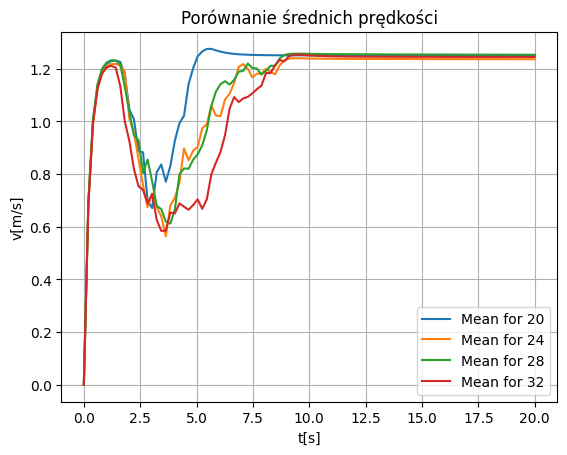

In [85]:
for i in range(4):
    vel_x_mean = np.mean(np.array(np.abs(all_solutions[i][:, 1, : ,0])), axis = 1)
    vel_y_mean = np.mean(np.array(np.abs(all_solutions[i][:, 1, : , 1])), axis  =1)
    plt.plot(np.linspace(0,20,100), np.sqrt(np.power(vel_x_mean,2)+np.power(vel_y_mean,2)), label = f"Mean for {20+i*4}")
    plt.legend()
plt.title("Porównanie średnich prędkości")
plt.xlabel('t[s]')
plt.ylabel('v[m/s]')
plt.grid()
plt.show() 

Z powyższego wykresu możemy odczytać, że im więcej pieszych próbuje sie wyminąc, tym bardziej spada ich średnia prędkość. Dodatkowo odpowiednio dłużej trwa okres obniżonej prędkości - czas w którym dwie grupy pieszych się mijają. 

### Symulacja przejścia przez drzwi w dwóch kierunkach
W kolejnej przygotowanej przez nas symulacji ruch pieszych również odbywa się w dwóch kierunkach, jednak dodatkowo pośrodku dwóch grup pieszych znajduje się jedno wąskie przejście, co można interpretować jako na przykład drzwi do budynku.

In [86]:
TIME_STEP = 100
T_SPAN = (0, 40)

particles = 10
#ida w lewo
crowd_1 = generate_positions(particles/2, (-10, -4, 6, 8), 1)
#ida w prawo
crowd_2 = generate_positions(particles/2, (6, -4, 6, 8), 1)

crowd = np.concatenate([crowd_1,crowd_2])

vel = np.zeros((particles, 2))

inital_conditions = np.concatenate([crowd_1, crowd_2, vel]).flatten()

e = np.concatenate([crowd_1_direction, crowd_2_direction])

#params
driving_w, rep_w, walls_w = [1,1,1]
m = np.random.rand(particles) + 1
v_0 = np.absolute(np.random.normal(1.24, 0.05, particles)) #zgodnie z artykułem
tau = np.full(particles, .5) #też zgodnie z artykułem - dla wszystkich równe
a = np.full(particles, .2)
b = np.full(particles, 1)
d = np.full(particles, .5)
door = np.array([0, 0])
e = np.array([(door-pos)/np.linalg.norm(door-pos) for pos in crowd])
boxes = np.array([[-15, -5, 30, 0], [-15, 5, 30, 0], [0, -5,0,4], [0, 1,0,4]])
params = (driving_w, rep_w, walls_w, particles, m, v_0, tau, a, b, d, e, boxes)

solution = solve_ivp(system, T_SPAN, inital_conditions, args=params, t_eval=np.linspace(T_SPAN[0], T_SPAN[1], TIME_STEP))
y = np.transpose(solution.y).reshape(TIME_STEP, 2, particles, 2)

#CZASAMI COS WYWALI WIEC TRZEBA POWTORZYC AZ ZADZIALA 

In [87]:
%%capture
fig, ax = plt.subplots(figsize=(5,5))
import matplotlib.patches as patches

def update(i):
    ax.clear()
    fig
    for particle in range(particles):
        ax.scatter(y[i, 0, particle, 0], y[i, 0, particle, 1])
    for box in boxes:
        bx, by, width, height = box
        if width == 0:
            width = 0.1
        if height == 0:
            height = 0.1
        rectangle = patches.Rectangle((bx, by), width, height, linewidth=1, edgecolor='gray', facecolor='gray')
        ax.add_patch(rectangle)

    ax.set_xlim(-10, 10) 
    ax.set_ylim(-10, 10)
    ax.axis('off')
    ax.set_title(f't = {i}')

ani = anim.FuncAnimation(fig, update, frames=50, interval=200)
ani.save('pedestrians.gif', writer='pillow')
ani.save('animation.html', writer='html')


In [88]:
HTML(ani.to_jshtml())

W wyniku dodania przeszkody ruch odbywa sie inaczej niż w poprzednim przypadku. Możemy zaobserwować, że grupa, która pierwsza dotarła do drzwi przechodzi przez nie po kolei w jedną stronę, a dopiero później piesi z drugiej strony mogą przejść. Biorąc pod uwagę, że nie rozpatrujemy czynników takich jak indywidualne zachowania pieszych - na przykład przepuszczanie się w drzwiach wynikające z konwencji społecznych, model ten w zbliżony sposób oddaje rzeczywistość.

#### Symulacja ludzi uciekających z pomieszczenia
Ostatnią symulacją jest ewakuacja pomieszczenia. W tym przypadku współczynnik decydujący o odległości między pieszymi został przez nas dostosowany, aby oddawał lepiej sytuację, w której ważniejsze jest dotarcie do zamierzonego celu - wyjścia ewakuacyjnego niż komfortowa odległość od innych.  
Na przygotowanej animacji umieszczone zostały dodatkowo wektory prędkości poszczególnych pieszych.

In [89]:


TIME_STEP = 100
T_SPAN = (0, 50)
particles = 50

crowd = generate_positions(particles, (-9, -9, 9, 18), 1)
emergency_exit = np.array([11, 0])

vel = np.zeros((particles, 2))
inital_conditions = np.concatenate([crowd, vel]).flatten()

driving_w = 1
rep_w = 0.2
walls_w = 1.5
m = np.random.rand(particles) + .2
v_0 = np.absolute(np.random.normal(1.24, 0.05, particles))
tau = np.full(particles, .5) #też zgodnie z artykułem - dla wszystkich równe
a = np.full(particles, .2)
b = np.full(particles, 1)
d = np.full(particles, 0.5)
e = np.array([(emergency_exit-pos)/np.linalg.norm(emergency_exit-pos) for pos in crowd])
boxes = np.array([[-11, -11, 22, 0], [-11, -11, 0, 22], [-11, 11, 22, 0], [11, -11, 0, 10], [11, 1, 0, 10]])
params = (driving_w, rep_w, walls_w, particles, m, v_0, tau, a, b, d, e, boxes)

solution = solve_ivp(system, T_SPAN, inital_conditions, args=params, t_eval=np.linspace(T_SPAN[0], T_SPAN[1], TIME_STEP))
y = np.transpose(solution.y).reshape(TIME_STEP, 2, particles, 2)


In [90]:
%%capture
fig, ax = plt.subplots(figsize=(7,7))

np.seterr(divide='ignore', invalid='ignore') #ignoruje dzielenie przez zero ito

def update(i):
    ax.clear()
    for particle in range(particles):
        ax.scatter(y[i, 0, particle, 0], y[i, 0, particle, 1])
        ax.quiver(y[i, 0, particle, 0], y[i, 0, particle, 1], y[i, 1, particle, 0], y[i, 1, particle, 1], linewidth=0.2)

    ax.set_xlim(-12, 25) 
    ax.set_ylim(-12, 12)

    ax.plot(np.linspace(-11, 11, 100), np.full(100, 11), color = "gray", linewidth = 2)
    ax.plot(np.linspace(-11, 11, 100), np.full(100, -11), color = "grey", linewidth = 2)
    ax.plot( np.full(100, -11), np.linspace(-11, 11, 100), color = "grey", linewidth = 2)
    ax.plot( np.full(100, 11), np.linspace(-11, -1, 100), color = "grey", linewidth = 2)
    ax.plot( np.full(100, 11), np.linspace(1, 11, 100), color = "grey", linewidth = 2)
    ax.axis('off')
    ax.set_title(f't = {i}')

ani = anim.FuncAnimation(fig, update, frames=80, interval=200)
ani.save('running_to_exit.gif', writer='pillow')
ani.save('running_to_exit.html', writer='html')

In [91]:
HTML(ani.to_jshtml())

Jak można zauważyć, w powyższym modelu założyliśmy, że od pierwszej chwili czasu wszyscy kierują się prosto w kierunku wyjścia ewakuacyjnego. Niestety, w rzeczywistości często mamy do czynienia z inną sytuacją, gdy ludzie ewakuujący się nie znają dobrze pomieszczenia, jak również, gdy uwzględnimy panikę towarzyszącą takiej sytuacji. Dlatego dodatkowo rozpatrzymy przypadek, gdy kierunek ruchu pieszych w początkowych chwilach zaburzony jest przez losowy czynnik, aby dopiero od pewnej chwili kierowali się prosto do wyjścia.

In [ ]:
T_SPAN = (0, 50)
TIME_STEP = T_SPAN[1]*2
particles = 50

crowd = generate_positions(particles, (-9, -9, 9, 18), 1)
emergency_exit = np.array([11, 0])

vel = np.zeros((particles, 2))
inital_conditions = np.concatenate([crowd, vel]).flatten()

driving_w = 1
rep_w = 0.19
walls_w = 1.5
m = np.random.rand(particles) + .2
v_0 = np.absolute(np.random.normal(1.24, 0.05, particles))
tau = np.full(particles, .5) #też zgodnie z artykułem - dla wszystkich równe
a = np.full(particles, .2)
b = np.full(particles, 1)
d = np.full(particles, 0.5)
e = np.array([(emergency_exit-pos)/np.linalg.norm(emergency_exit-pos) for pos in crowd])

boxes = np.array([[-11, -11, 22, 0], [-11, -11, 0, 22], [-11, 11, 22, 0], [11, -11, 0, 10], [11, 1, 0, 10]])
params = (driving_w, rep_w, walls_w, particles, m, v_0, tau, a, b, d, e, boxes, T_SPAN[1], emergency_exit)

solution = solve_ivp(system, T_SPAN, inital_conditions, args=params, t_eval=np.linspace(T_SPAN[0], T_SPAN[1], TIME_STEP))
y = np.transpose(solution.y).reshape(TIME_STEP, 2, particles, 2)

In [ ]:
%%capture
fig, ax = plt.subplots(figsize=(7,7))

np.seterr(divide='ignore', invalid='ignore') #ignoruje dzielenie przez zero ito

def update(i):
    ax.clear()
    for particle in range(particles):
        ax.scatter(y[i, 0, particle, 0], y[i, 0, particle, 1])
        ax.quiver(y[i, 0, particle, 0], y[i, 0, particle, 1], y[i, 1, particle, 0], y[i, 1, particle, 1])

    ax.set_xlim(-12, 25) 
    ax.set_ylim(-12, 12)

    ax.plot(np.linspace(-11, 11, 100), np.full(100, 11), color = "gray", linewidth = 2)
    ax.plot(np.linspace(-11, 11, 100), np.full(100, -11), color = "grey", linewidth = 2)
    ax.plot( np.full(100, -11), np.linspace(-11, 11, 100), color = "grey", linewidth = 2)
    ax.plot( np.full(100, 11), np.linspace(-11, -1, 100), color = "grey", linewidth = 2)
    ax.plot( np.full(100, 11), np.linspace(1, 11, 100), color = "grey", linewidth = 2)
    ax.axis('off')
    ax.set_title(f't = {i}')

ani = anim.FuncAnimation(fig, update, frames=TIME_STEP, interval=200)
ani.save('running_to_exit_random.gif', writer='pillow')
ani.save('running_to_exit_random.html', writer='html')

In [ ]:
HTML(ani.to_jshtml())

### Wnioski

Zachowanie pieszych może być opisane z wykorzystaniem modelu wykorzystującego dwie proste siły. Pomimo dużych uproszczeń, przeprowadzone symulacje pokazały, że dobrze oddaje on rzeczywistość.  


### Bibliografia:

<a href="https://doi.org/10.1016/j.physa.2005.11.052" id="1">[1] *Basics of modelling the pedestrian flow* - Armin Seyfried, Bernhard Steffen, Thomas Lippert<a/>

<a href="https://journals.aps.org/pre/abstract/10.1103/PhysRevE.51.4282" id="2">[2] *Social force model for pedestrian dynamics* - Dirk Helbing and Peter Molnar<a/>  

<a href="https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.84.1240" id="3">[3] *Freezing by Heating in a Pedestrian Model* - Dirk Helbing, llés J. Farkas, Tamás Vicsek<a/>